# Analysis for Figure 1D Flow cytometry analysis

In [2]:
import fcsparser
import numpy as np
import pandas as pd
import glob
import matplotlib.pyplot as plt
import seaborn as sns
import re
import scipy

import mpl_scatter_density # adds projection='scatter_density'
from matplotlib.colors import LinearSegmentedColormap
from scipy.stats import ttest_ind

import itertools
from scipy import stats
from statsmodels.stats.multitest import multipletests



In [3]:
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = 7
cm = 1/2.54
fig_folder = './Figure_1_exports'
data_folder = '../all_data/Figure_1_data'

## Load all data and associate the key with the flow samples

In [4]:
'/'.join([data_folder,'all_flow_samples/*.fcs'])

'../all_data/Figure_1_data/all_flow_samples/*.fcs'

In [5]:
flow_paths = glob.glob('/'.join([data_folder,'all_flow_samples/*.fcs']))

all_data = []

for i,path in enumerate(flow_paths):
    meta, data = fcsparser.parse(path, meta_data_only=False, reformat_meta=True)
    data['flow_number'] = i
    name = path.split('\\')[-1].split('.')[0]
    well = re.findall(r'p[0-9]_([A-Z][0-9]{1,2}).*',name)[0]
    plate = int(re.findall(r'p([0-9]{1})_.*',name)[0])

    print(name,well,plate)
    data['flow_name'] = name
    data['plate'] = plate
    data['well_name'] = well
    all_data.append(data)

all_data = pd.concat(all_data).reset_index(drop=True)
all_data

p1_A10_blank_2 A10 1
p1_A22_blank_11 A22 1
p1_B10_AqpZ_3 B10 1
p1_B22_AqpZ_12 B22 1
p1_C10_MscL_4 C10 1
p1_C22_MscL_13 C22 1
p1_F13_blank_14 F13 1
p1_F16_AqpZ_15 F16 1
p1_F19_MscL_16 F19 1
p1_F1_blank_5 F1 1
p1_F4_AqpZ_6 F4 1
p1_F7_MscL_7 F7 1
p1_G1_blank_8 G1 1
p1_G4_AqpZ_9 G4 1
p1_G7_MscL_10 G7 1
p2_A24_Blank_17 A24 2
p2_D24_AqpZ_18 D24 2
p2_F15_blank_20 F15 2
p2_F18_AqpZ_21 F18 2
p2_F21_MscL_22 F21 2
p2_G24_MscL_19 G24 2
p3_A1_Cat-DOPC_0_15 A1 3
p3_A2_Cat-DOPC_0_36 A2 3
p3_A3_Cat-DOPC_0_58 A3 3
p3_A4_Cat-DMPC_0_16 A4 3
p3_A5_Cat-DMPC_0_37 A5 3
p3_A6_Cat-DMPC_0_59 A6 3
p3_A7_Cat-PEG_0_17 A7 3
p3_A8_Cat-PEG_0_38 A8 3
p3_A9_Cat-PEG_0_60 A9 3
p3_F1_Cat-DOPC_1200_4 F1 3
p3_F2_Cat-DOPC_1200_25 F2 3
p3_F3_Cat-DOPC_1200_47 F3 3
p3_F4_Cat-DMPC_1200_5 F4 3
p3_F5_Cat-DMPC_1200_26 F5 3
p3_F6_Cat-DMPC_1200_48 F6 3
p3_F7_Cat-PEG_1200_6 F7 3
p3_F8_Cat-PEG_1200_27 F8 3
p3_F9_Cat-PEG_1200_49 F9 3


FSC-H         FSC-A         SSC-H         SSC-A   B-525-40-H  \
0         6287.399902 -10357.400391   2613.600098   5263.899902   431.100006   
1        11700.799805   4993.200195   3278.500000   6064.600098   813.900024   
2        11715.599609   7912.399902  21920.800781  60831.300781  1813.099976   
3        10293.000000   3101.199951    642.200012    497.299988   874.799988   
4        13899.900391   3488.000000   1213.099976   2040.199951   580.200012   
...               ...           ...           ...           ...          ...   
3973920   5156.399902      1.100000   2200.300049   4416.700195  2058.800049   
3973921   2941.199951  -8051.799805   2563.000000   3137.500000  2234.000000   
3973922   8174.399902   2467.800049    581.299988   -159.600006   940.799988   
3973923   8902.500000    966.299988    578.000000    674.900024   145.000000   
3973924   5743.899902   1290.699951   1498.900024   1124.199951  1498.000000   

          B-525-40-A  B-690-50-H  B-690-50-A    R-660-20-H    R-660-20-A  ...  \
0        -448.000000  575.400024  226.899994   2148.000000   4440.899902  ...   
1           2.000000  544.400024  437.000000   2379.500000   4115.799805  ...   
2        1933.300049  790.900024  955.200012  13270.900391  22404.800781  ...   
3        -672.599976  354.500000 -103.599998   2244.399902   1790.300049  ...   
4        -278.200012  395.700012  182.399994   2852.199951   4464.600098  ...   
...              ...         ...         ...           ...           ...  ...   
3973920  3959.500000  324.000000  120.300003   2787.600098   5370.600098  ...   
3973921  3048.100098  513.400024  276.399994   3422.800049   6404.200195  ...   
3973922   239.800003  486.200012  329.000000   2880.500000   1885.500000  ...   
3973923  -937.500000  409.200012   42.799999   2005.800049   1747.800049  ...   
3973924   725.200012  239.699997   84.000000   2170.500000   3178.800049  ...   

          Y-690-50-H   Y-690-50-A  Y-780-60-H  Y-780-60-A  405-10-Width  \
0        1142.800049  1107.199951  233.199997  -94.400002   1388.640869   
1        1297.400024  1752.300049  251.699997  161.600006   1386.901001   
2        3194.600098  4702.100098  487.000000  496.399994   2227.084961   
3         628.200012   491.899994  269.200012  158.500000    211.199997   
4        1077.400024  1378.400024  385.700012   68.400002   1536.364380   
...              ...          ...         ...         ...           ...   
3973920  1358.500000  1800.500000  526.400024  468.600006   1052.806763   
3973921  1593.599976  1679.800049  374.899994  258.299988    825.485901   
3973922   297.200012   186.800003  300.399994  -79.500000  -6473.739258   
3973923   579.500000   445.100006  302.000000  -19.200001   -173.002106   
3973924   683.099976   632.599976  363.200012  174.300003   -961.350220   

              Time  flow_number              flow_name  plate  well_name  
0              0.0            0         p1_A10_blank_2      1        A10  
1             32.0            0         p1_A10_blank_2      1        A10  
2             49.0            0         p1_A10_blank_2      1        A10  
3             52.0            0         p1_A10_blank_2      1        A10  
4             57.0            0         p1_A10_blank_2      1        A10  
...            ...          ...                    ...    ...        ...  
3973920  3261635.0           38  p3_F9_Cat-PEG_1200_49      3         F9  
3973921  3261669.0           38  p3_F9_Cat-PEG_1200_49      3         F9  
3973922  3261683.0           38  p3_F9_Cat-PEG_1200_49      3         F9  
3973923  3261696.0           38  p3_F9_Cat-PEG_1200_49      3         F9  
3973924  3261725.0           38  p3_F9_Cat-PEG_1200_49      3         F9  

[3973925 rows x 36 columns]

In [6]:
meta = pd.read_excel('/'.join([data_folder,'Fig1D-flow_key.xlsx']))
meta

DNA_name Liposome_name well_name  plate  Rep  Volume
0     Blank  DOPC_005_Cy5       A10      1    1       0
1     Blank  DOPC_005_Cy5       A11      1    1       0
2     Blank  DOPC_005_Cy5       A12      1    1       0
3      AqpZ  DOPC_005_Cy5       B10      1    1       0
4      AqpZ  DOPC_005_Cy5       B11      1    1       0
..      ...           ...       ...    ...  ...     ...
76      Cat  DOPC_005_Cy5        F5      3    2    1200
77      Cat  DOPC_005_Cy5        F6      3    2    1200
78      Cat  DOPC_005_Cy5        F7      3    3    1200
79      Cat  DOPC_005_Cy5        F8      3    3    1200
80      Cat  DOPC_005_Cy5        F9      3    3    1200

[81 rows x 6 columns]

In [7]:
all_data = all_data.set_index(['plate','well_name']).join(meta.set_index(['plate','well_name'])).reset_index()
all_data

plate well_name         FSC-H         FSC-A         SSC-H  \
0            1       A10   6287.399902 -10357.400391   2613.600098   
1            1       A10  11700.799805   4993.200195   3278.500000   
2            1       A10  11715.599609   7912.399902  21920.800781   
3            1       A10  10293.000000   3101.199951    642.200012   
4            1       A10  13899.900391   3488.000000   1213.099976   
...        ...       ...           ...           ...           ...   
3973920      3        F9   5156.399902      1.100000   2200.300049   
3973921      3        F9   2941.199951  -8051.799805   2563.000000   
3973922      3        F9   8174.399902   2467.800049    581.299988   
3973923      3        F9   8902.500000    966.299988    578.000000   
3973924      3        F9   5743.899902   1290.699951   1498.900024   

                SSC-A   B-525-40-H   B-525-40-A  B-690-50-H  B-690-50-A  ...  \
0         5263.899902   431.100006  -448.000000  575.400024  226.899994  ...   
1         6064.600098   813.900024     2.000000  544.400024  437.000000  ...   
2        60831.300781  1813.099976  1933.300049  790.900024  955.200012  ...   
3          497.299988   874.799988  -672.599976  354.500000 -103.599998  ...   
4         2040.199951   580.200012  -278.200012  395.700012  182.399994  ...   
...               ...          ...          ...         ...         ...  ...   
3973920   4416.700195  2058.800049  3959.500000  324.000000  120.300003  ...   
3973921   3137.500000  2234.000000  3048.100098  513.400024  276.399994  ...   
3973922   -159.600006   940.799988   239.800003  486.200012  329.000000  ...   
3973923    674.900024   145.000000  -937.500000  409.200012   42.799999  ...   
3973924   1124.199951  1498.000000   725.200012  239.699997   84.000000  ...   

         Y-780-60-H  Y-780-60-A  405-10-Width       Time  flow_number  \
0        233.199997  -94.400002   1388.640869        0.0            0   
1        251.699997  161.600006   1386.901001       32.0            0   
2        487.000000  496.399994   2227.084961       49.0            0   
3        269.200012  158.500000    211.199997       52.0            0   
4        385.700012   68.400002   1536.364380       57.0            0   
...             ...         ...           ...        ...          ...   
3973920  526.400024  468.600006   1052.806763  3261635.0           38   
3973921  374.899994  258.299988    825.485901  3261669.0           38   
3973922  300.399994  -79.500000  -6473.739258  3261683.0           38   
3973923  302.000000  -19.200001   -173.002106  3261696.0           38   
3973924  363.200012  174.300003   -961.350220  3261725.0           38   

                     flow_name  DNA_name  Liposome_name  Rep  Volume  
0               p1_A10_blank_2     Blank   DOPC_005_Cy5    1       0  
1               p1_A10_blank_2     Blank   DOPC_005_Cy5    1       0  
2               p1_A10_blank_2     Blank   DOPC_005_Cy5    1       0  
3               p1_A10_blank_2     Blank   DOPC_005_Cy5    1       0  
4               p1_A10_blank_2     Blank   DOPC_005_Cy5    1       0  
...                        ...       ...            ...  ...     ...  
3973920  p3_F9_Cat-PEG_1200_49       Cat   DOPC_005_Cy5    3    1200  
3973921  p3_F9_Cat-PEG_1200_49       Cat   DOPC_005_Cy5    3    1200  
3973922  p3_F9_Cat-PEG_1200_49       Cat   DOPC_005_Cy5    3    1200  
3973923  p3_F9_Cat-PEG_1200_49       Cat   DOPC_005_Cy5    3    1200  
3973924  p3_F9_Cat-PEG_1200_49       Cat   DOPC_005_Cy5    3    1200  

[3973925 rows x 40 columns]

In [8]:
all_data[all_data['DNA_name'].isna()]

Empty DataFrame
Columns: [plate, well_name, FSC-H, FSC-A, SSC-H, SSC-A, B-525-40-H, B-525-40-A, B-690-50-H, B-690-50-A, R-660-20-H, R-660-20-A, R-712-25-H, R-712-25-A, R-780-60-H, R-780-60-A, 405-10-H, 405-10-A, V-450-45-H, V-450-45-A, V-610-20-H, V-610-20-A, V-660-20-H, V-660-20-A, Y-585-42-H, Y-585-42-A, Y-610-20-H, Y-610-20-A, Y-690-50-H, Y-690-50-A, Y-780-60-H, Y-780-60-A, 405-10-Width, Time, flow_number, flow_name, DNA_name, Liposome_name, Rep, Volume]
Index: []

[0 rows x 40 columns]

### Clip the extreme values that are beyond the possible bounds

In [9]:
all_data['B-525-40-A'] = all_data['B-525-40-A'].clip(10**-3,10**8)
all_data['R-660-20-A'] = all_data['R-660-20-A'].clip(10**-3,10**8)
all_data['SSC-A'] = all_data['SSC-A'].clip(10**-3,10**8)

### Investigate all samples with no expressed proteins

c:\Users\conar\Memplex_platform\analysis_env\Lib\site-packages\mpl_scatter_density\generic_density_artist.py:77: RuntimeWarning: All-NaN slice encountered
  vmin = self._density_vmin(array)
c:\Users\conar\Memplex_platform\analysis_env\Lib\site-packages\mpl_scatter_density\generic_density_artist.py:82: RuntimeWarning: All-NaN slice encountered
  vmax = self._density_vmax(array)


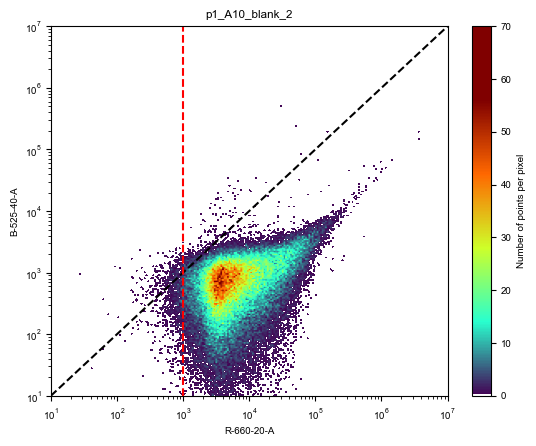

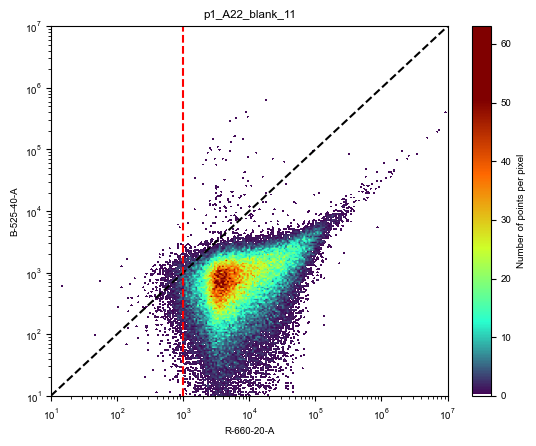

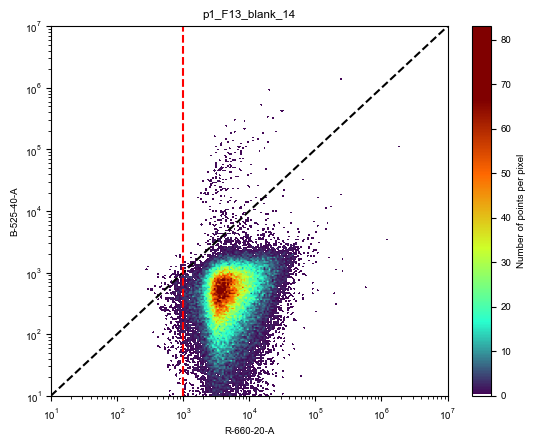

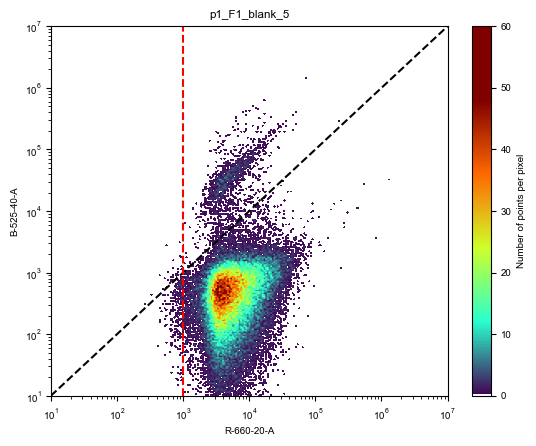

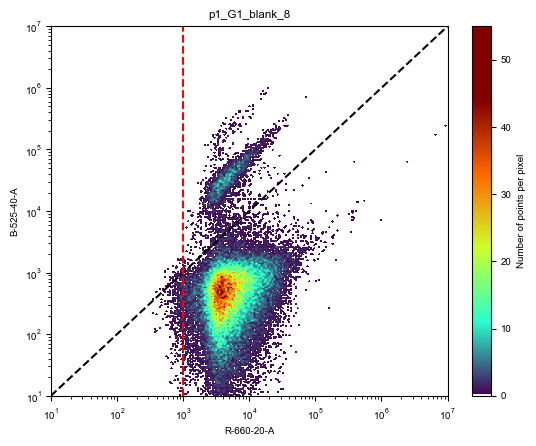

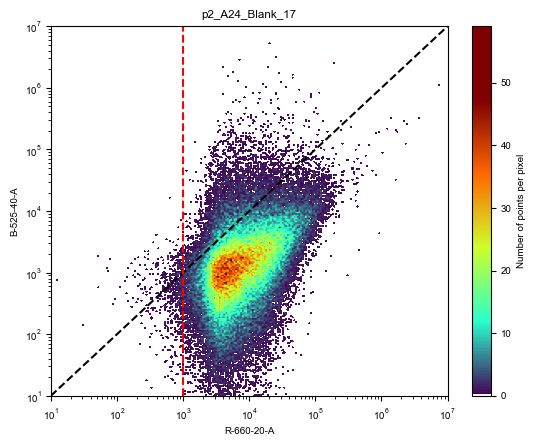

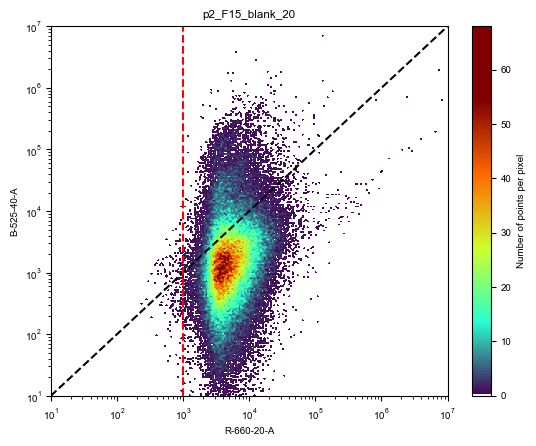

In [10]:
white_jet = LinearSegmentedColormap.from_list('white_jet', [
    (0, '#ffffff'),
    (1e-20, '#440053'),
    (0.2, '#29ffce'),
    (0.4, '#ceff29'),
    (0.6, '#ff6800'),
    (0.8, '#800000'),
    (1, '#800000'),
], N=256)

def using_mpl_scatter_density(fig, x, y):
    ax = fig.add_subplot(1, 1, 1, projection='scatter_density')
    density = ax.scatter_density(x, y, cmap=white_jet)
    plt.xscale('log')
    plt.yscale('log')

    plt.xlim([10**1,10**7])
    plt.ylim([10,10**7])

    fig.colorbar(density, label='Number of points per pixel')

x_label = 'R-660-20-A'
y_label = 'B-525-40-A'

for dna,df in all_data[all_data['DNA_name'] == 'Blank'].groupby('flow_name'):
    x = np.array(df[x_label].tolist())
    y = np.array(df[y_label].tolist())
    
    fig = plt.figure()
    using_mpl_scatter_density(fig, x, y)
    plt.title(dna)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.plot([10**1,10**7],[10**1,10**7],c='k',ls='--')
    plt.axvline(10**3,ls='--',c='red')
    
    
    plt.show()


In [11]:
all_data.columns

Index(['plate', 'well_name', 'FSC-H', 'FSC-A', 'SSC-H', 'SSC-A', 'B-525-40-H',
       'B-525-40-A', 'B-690-50-H', 'B-690-50-A', 'R-660-20-H', 'R-660-20-A',
       'R-712-25-H', 'R-712-25-A', 'R-780-60-H', 'R-780-60-A', '405-10-H',
       '405-10-A', 'V-450-45-H', 'V-450-45-A', 'V-610-20-H', 'V-610-20-A',
       'V-660-20-H', 'V-660-20-A', 'Y-585-42-H', 'Y-585-42-A', 'Y-610-20-H',
       'Y-610-20-A', 'Y-690-50-H', 'Y-690-50-A', 'Y-780-60-H', 'Y-780-60-A',
       '405-10-Width', 'Time', 'flow_number', 'flow_name', 'DNA_name',
       'Liposome_name', 'Rep', 'Volume'],
      dtype='object')

### Define criteria for liposomes
* Setting the criteria as a range of Cy5/SSC because there should be a roughly normal distribution of Cy5 on a given size of liposome
* By looking for ones that fit that criteria it gets rid of large events that have minimal Cy5

c:\Users\conar\Memplex_platform\analysis_env\Lib\site-packages\mpl_scatter_density\generic_density_artist.py:77: RuntimeWarning: All-NaN slice encountered
  vmin = self._density_vmin(array)
c:\Users\conar\Memplex_platform\analysis_env\Lib\site-packages\mpl_scatter_density\generic_density_artist.py:82: RuntimeWarning: All-NaN slice encountered
  vmax = self._density_vmax(array)


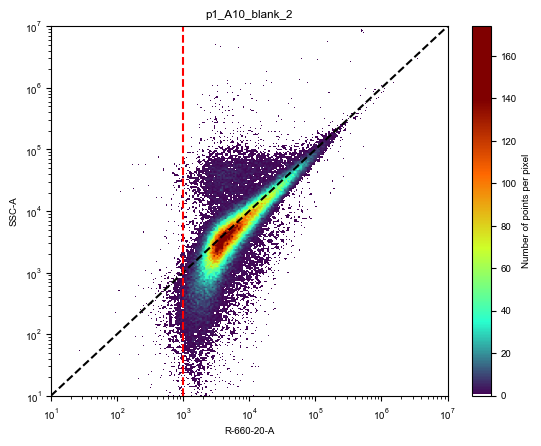

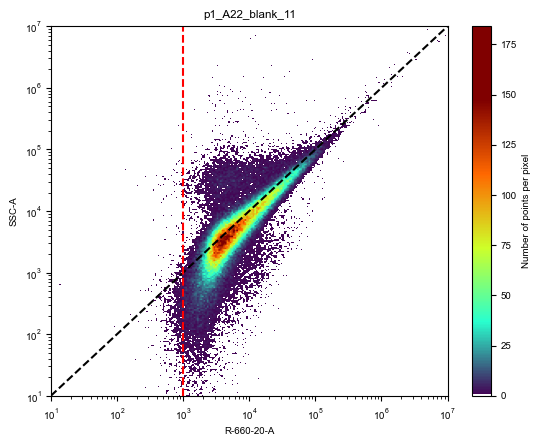

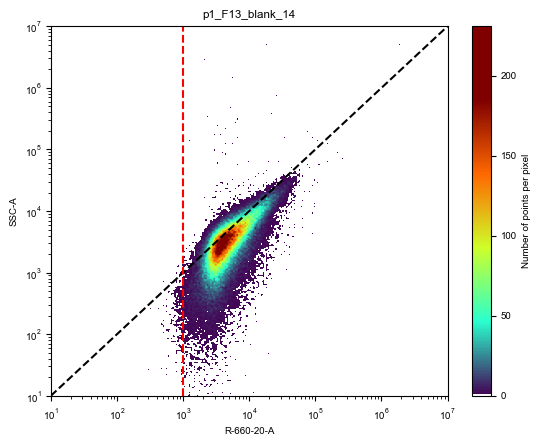

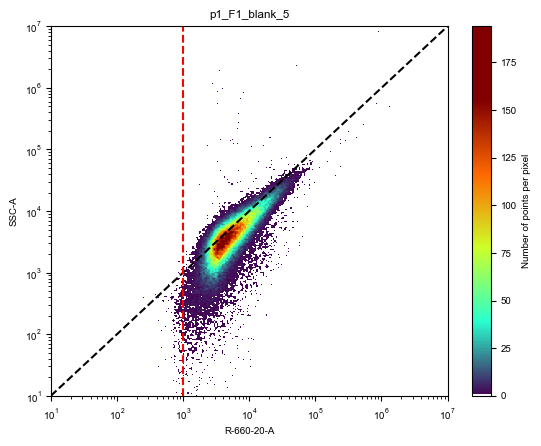

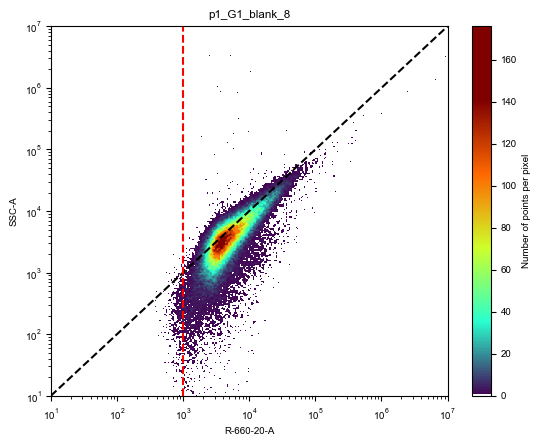

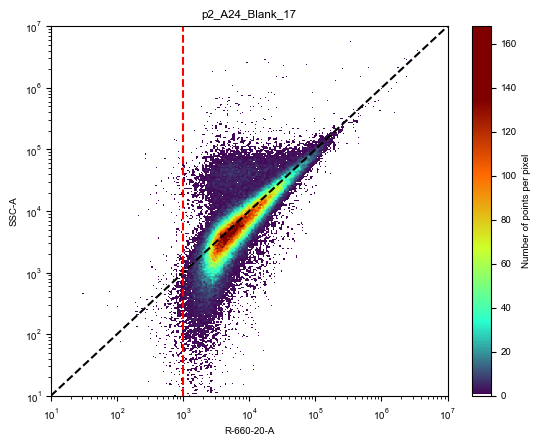

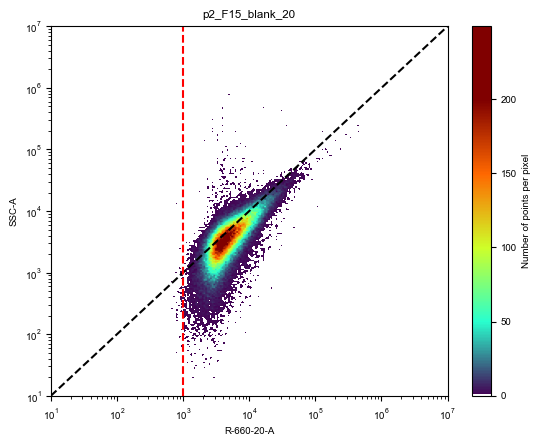

In [12]:
x_label = 'R-660-20-A'
y_label = 'SSC-A'

for dna,df in all_data[all_data['DNA_name'] == 'Blank'].groupby('flow_name'):
    x = np.array(df[x_label].tolist())
    y = np.array(df[y_label].tolist())
    
    fig = plt.figure()
    using_mpl_scatter_density(fig, x, y)
    plt.title(dna)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.plot([10**1,10**7],[10**1,10**7],c='k',ls='--')
    plt.axvline(10**3,ls='--',c='red')
    
    
    plt.show()


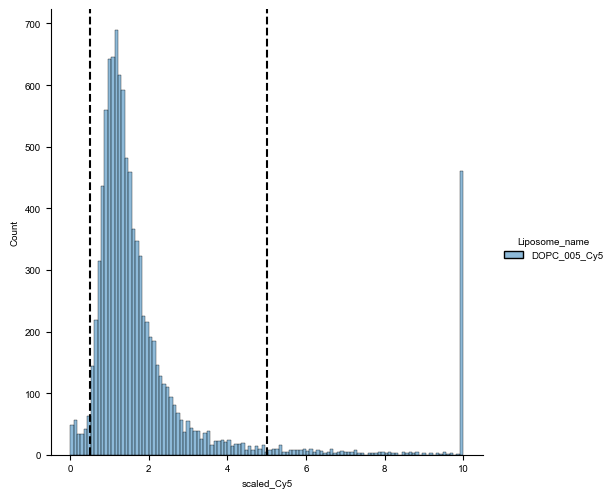

In [13]:
x_label = 'R-660-20-A'
y_label = 'SSC-A'
temp = all_data[all_data['DNA_name'] == 'Blank'].sample(10000)
temp['scaled_Cy5'] = temp[x_label] / temp[y_label] 
temp['scaled_Cy5'].describe()
temp['scaled_Cy5'] = temp['scaled_Cy5'].clip(0,10)
sns.displot(data=temp,x='scaled_Cy5',hue='Liposome_name',)
lipo_low = 0.5
lipo_high = 5
plt.axvline(lipo_low,color='black',ls='--')
plt.axvline(lipo_high,color='black',ls='--')
plt.show()

### Remove all events that fall outside the expected range of Cy5:SSC as these are likely contaminant events

c:\Users\conar\Memplex_platform\analysis_env\Lib\site-packages\mpl_scatter_density\generic_density_artist.py:77: RuntimeWarning: All-NaN slice encountered
  vmin = self._density_vmin(array)
c:\Users\conar\Memplex_platform\analysis_env\Lib\site-packages\mpl_scatter_density\generic_density_artist.py:82: RuntimeWarning: All-NaN slice encountered
  vmax = self._density_vmax(array)


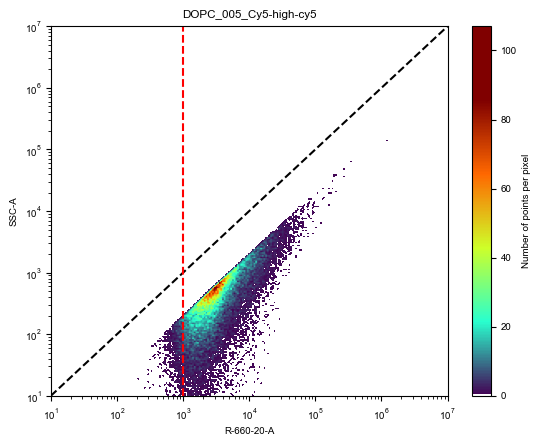

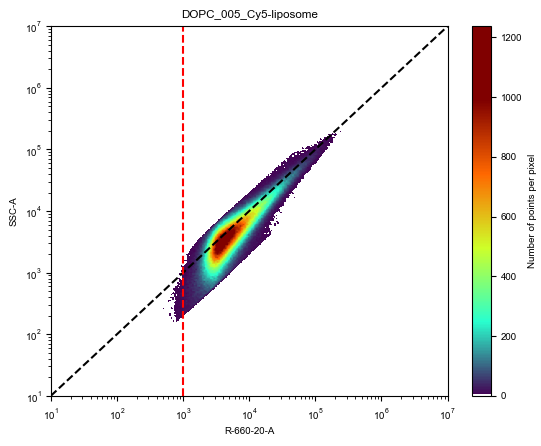

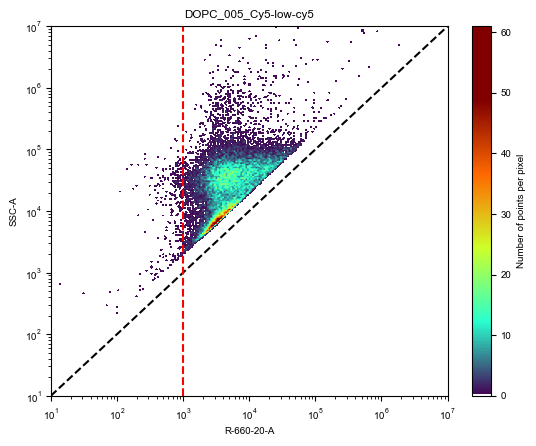

In [14]:
def assign_lipo(scaled,high=5,low=0.5):
    if scaled > high:
        return 'high-cy5'
    elif scaled > low:
        return 'liposome'
    else:
        return 'low-cy5'
    
    
    
all_data['scaled_Cy5'] = all_data['R-660-20-A'] / all_data['SSC-A'] 
all_data['lipo_class'] = all_data['scaled_Cy5'].apply(assign_lipo,high=lipo_high,low=lipo_low)

x_label = 'R-660-20-A'
y_label = 'SSC-A'

for [lipo,label],df in all_data[(all_data['DNA_name'] == 'Blank')].groupby(['Liposome_name','lipo_class']):
    x = np.array(df[x_label].tolist())
    y = np.array(df[y_label].tolist())
    
    fig = plt.figure()
    using_mpl_scatter_density(fig, x, y)
    plt.title(f'{lipo}-{label}')
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.plot([10**1,10**7],[10**1,10**7],c='k',ls='--')
    plt.axvline(10**3,ls='--',c='red')
    
    
    plt.show()


c:\Users\conar\Memplex_platform\analysis_env\Lib\site-packages\mpl_scatter_density\generic_density_artist.py:77: RuntimeWarning: All-NaN slice encountered
  vmin = self._density_vmin(array)
c:\Users\conar\Memplex_platform\analysis_env\Lib\site-packages\mpl_scatter_density\generic_density_artist.py:82: RuntimeWarning: All-NaN slice encountered
  vmax = self._density_vmax(array)


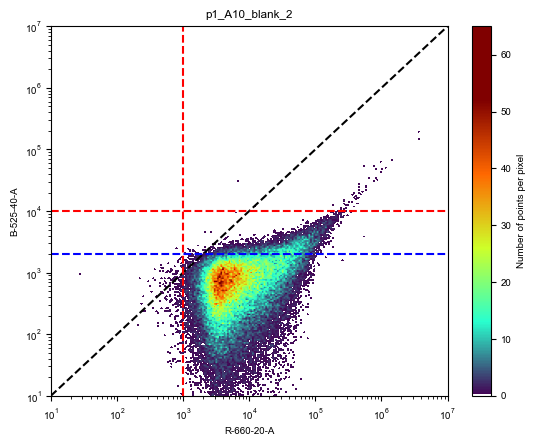

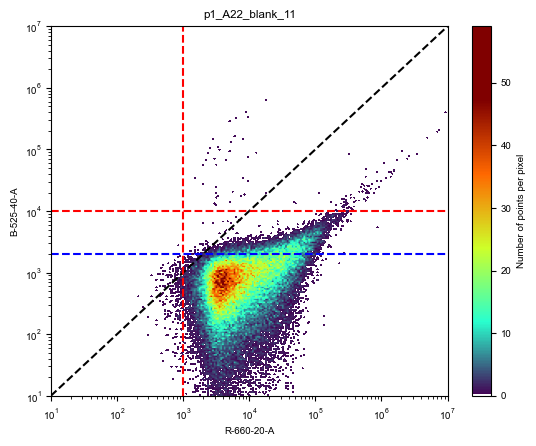

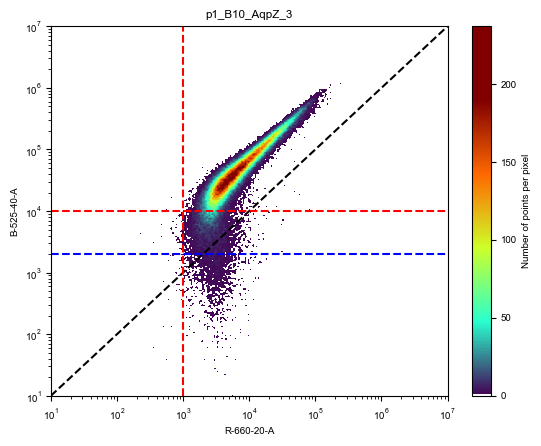

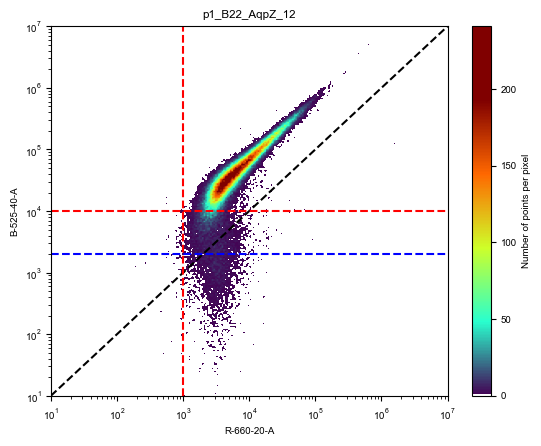

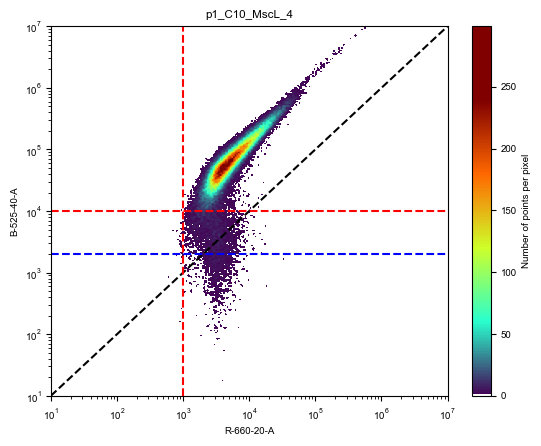

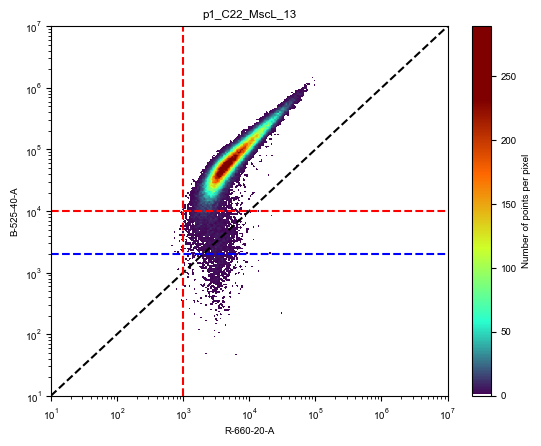

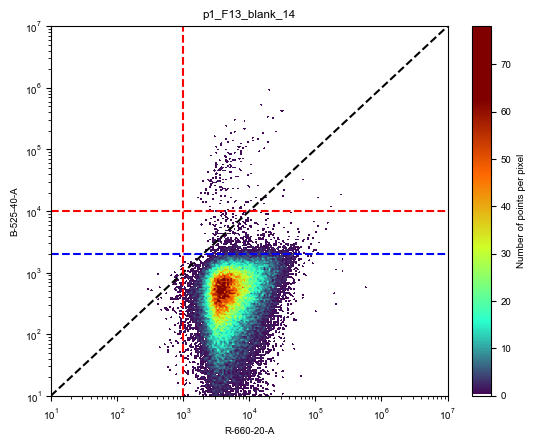

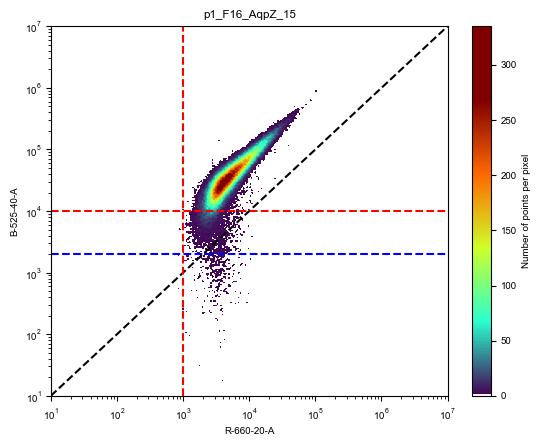

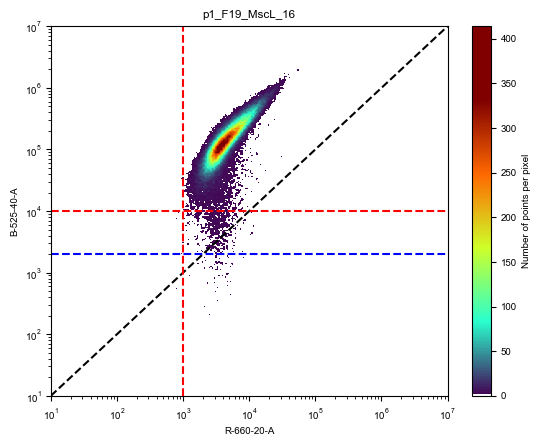

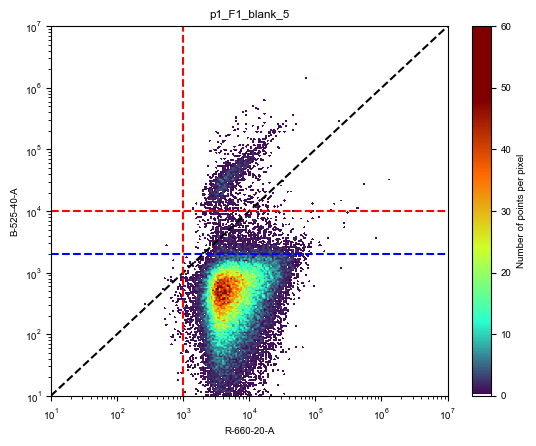

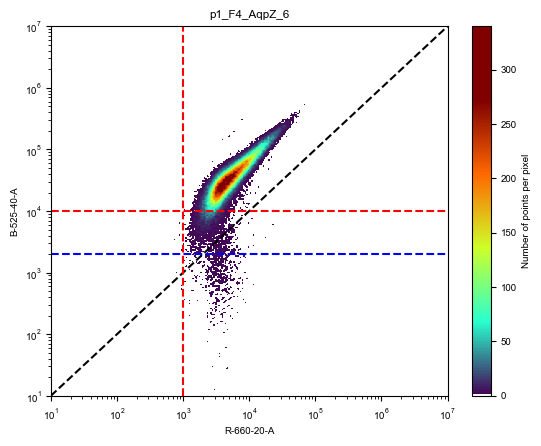

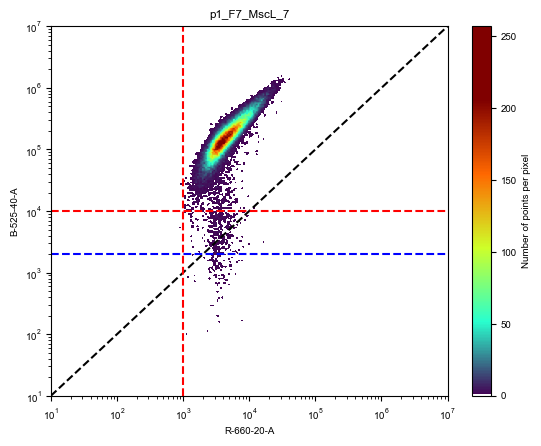

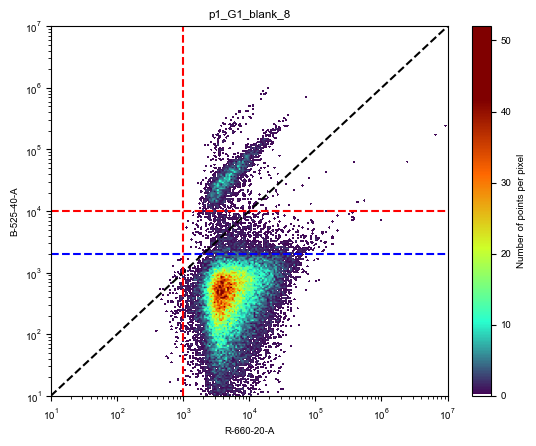

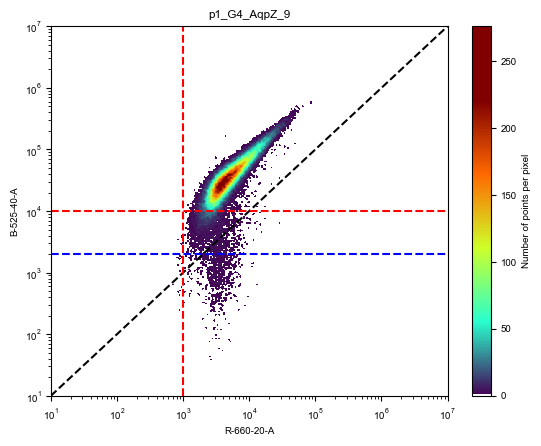

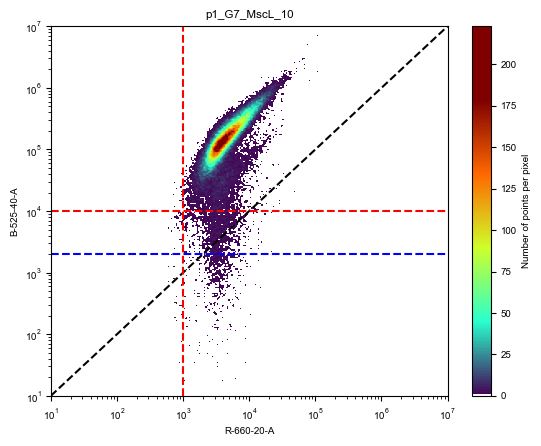

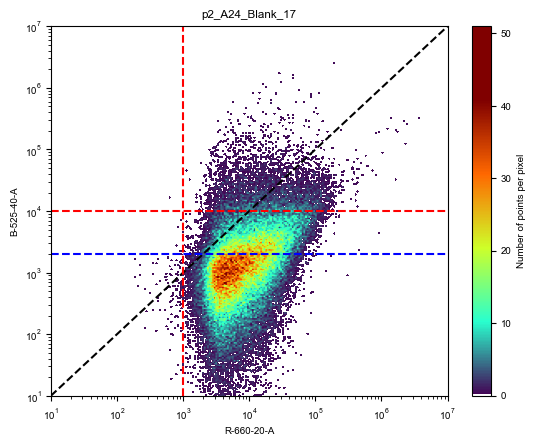

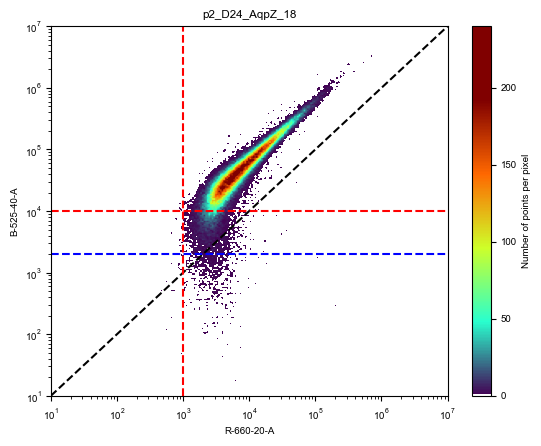

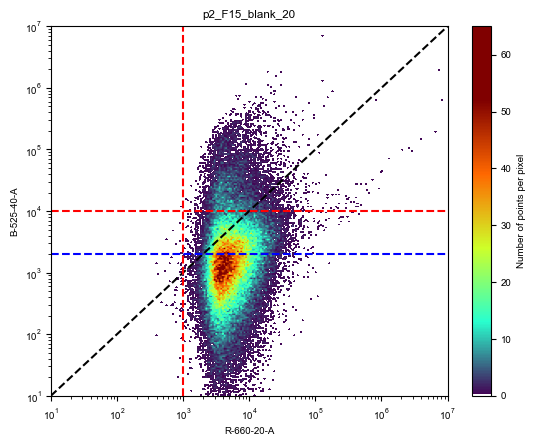

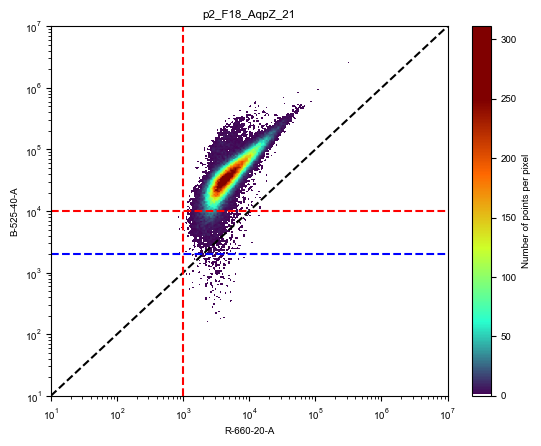

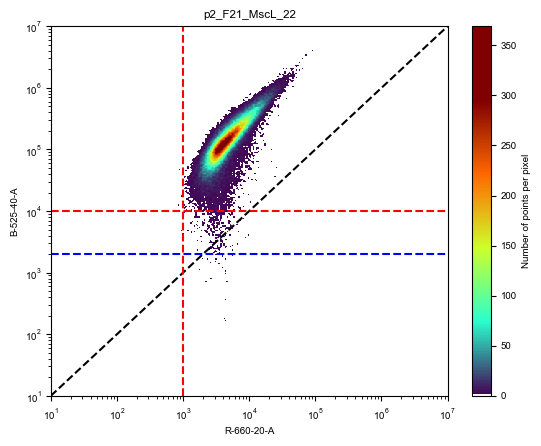

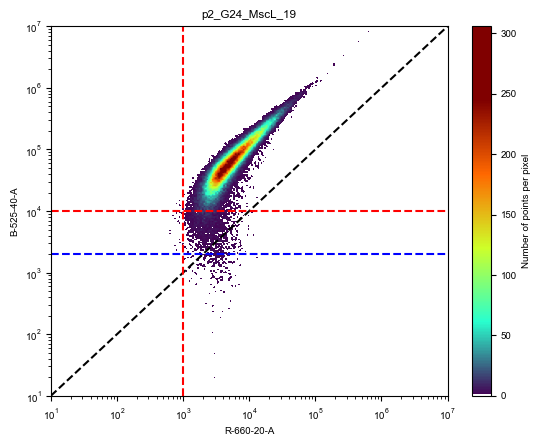

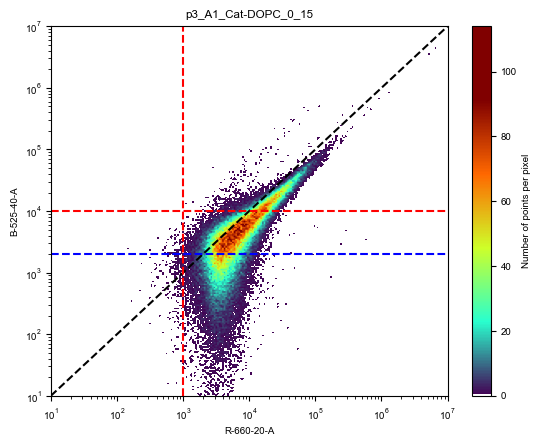

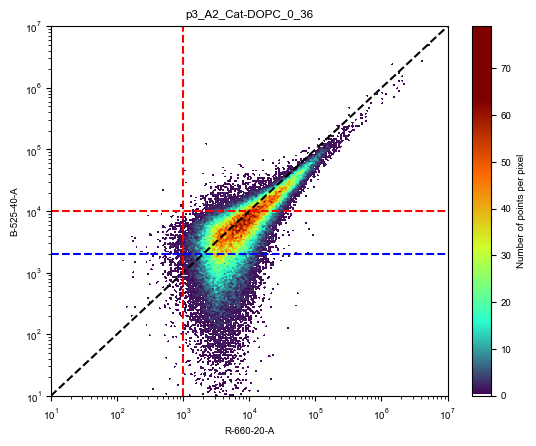

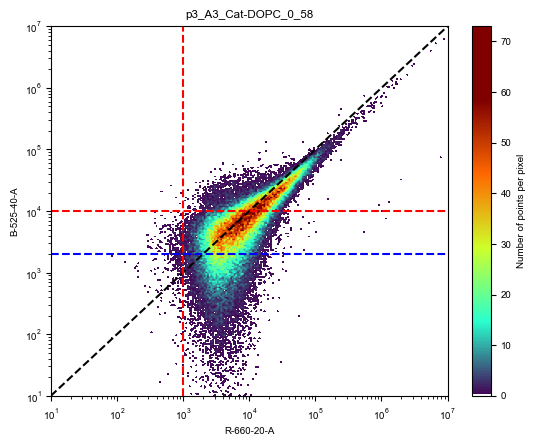

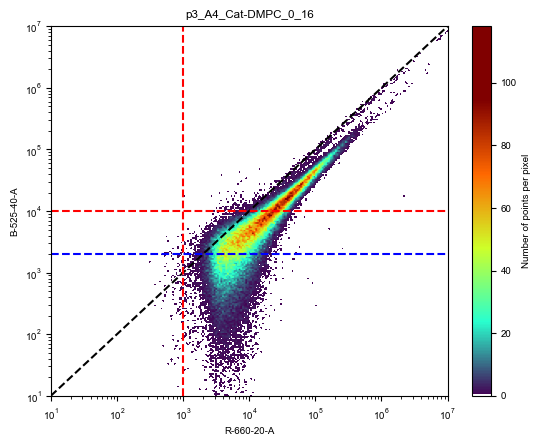

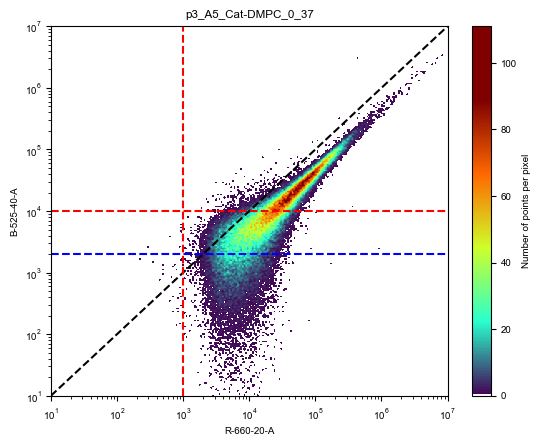

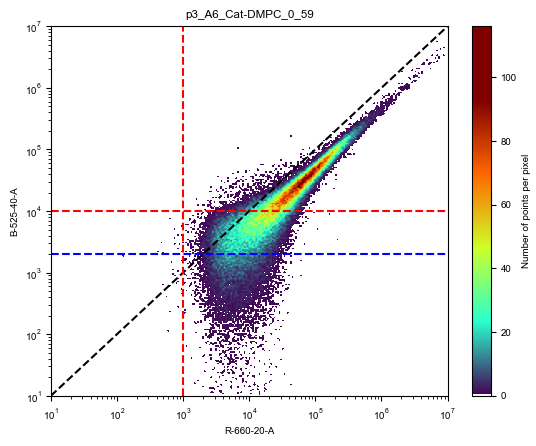

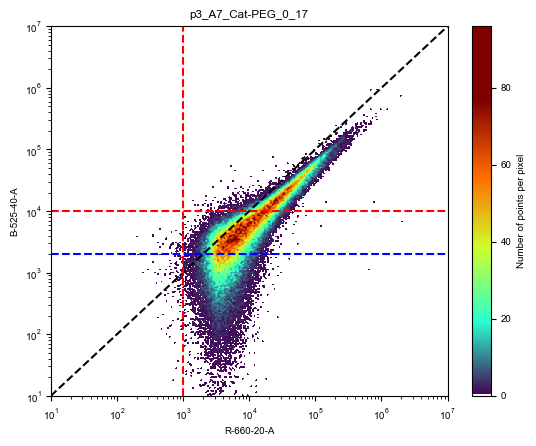

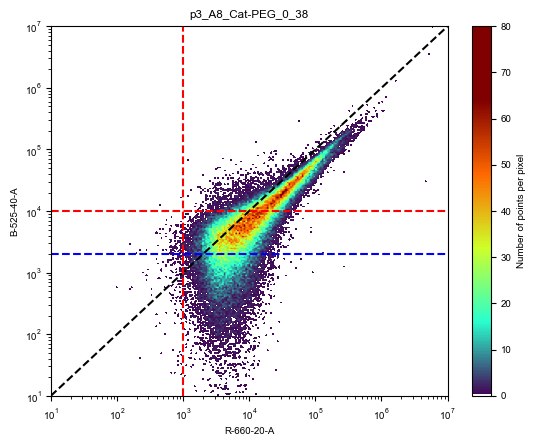

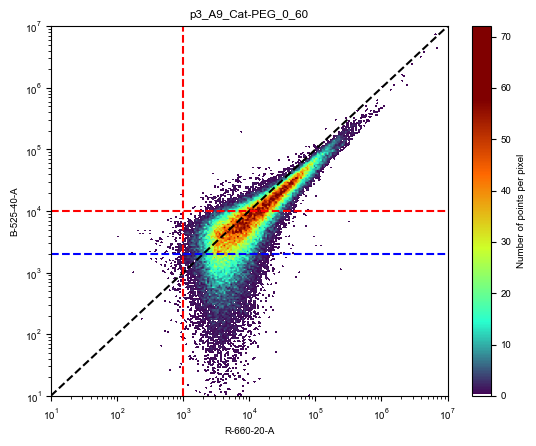

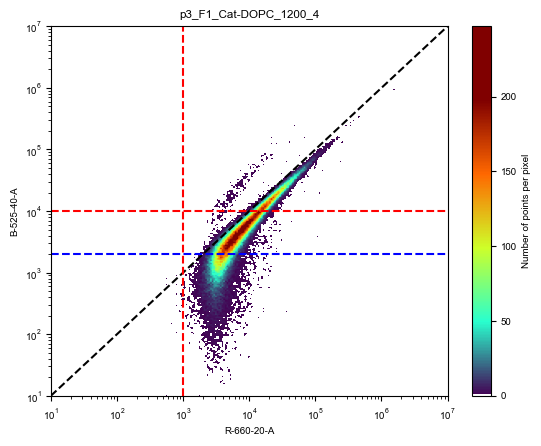

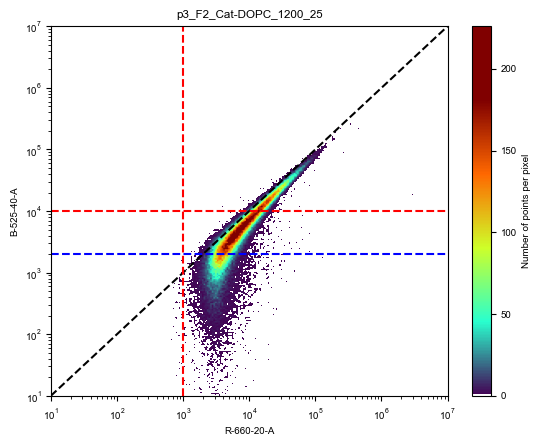

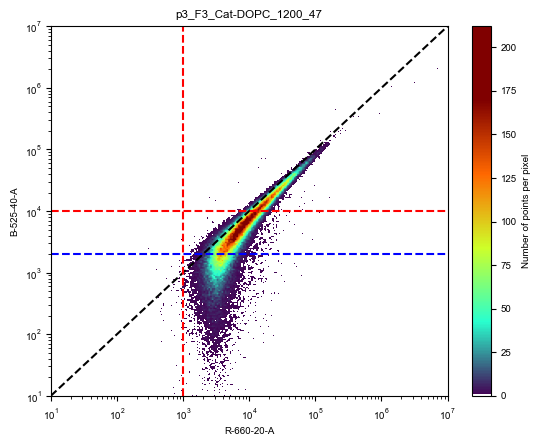

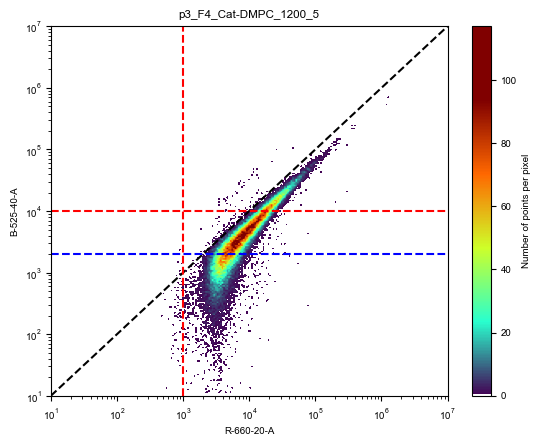

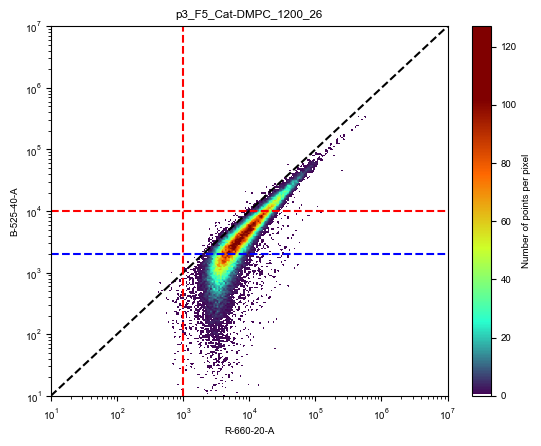

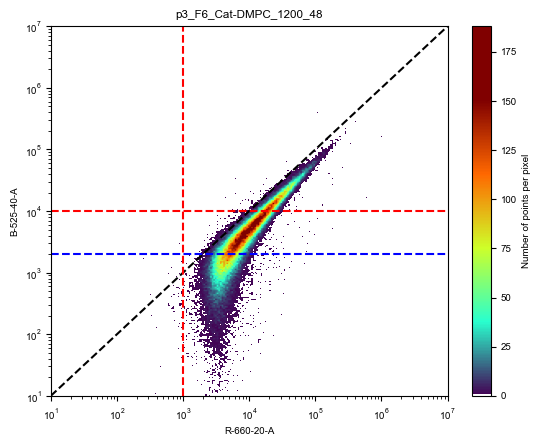

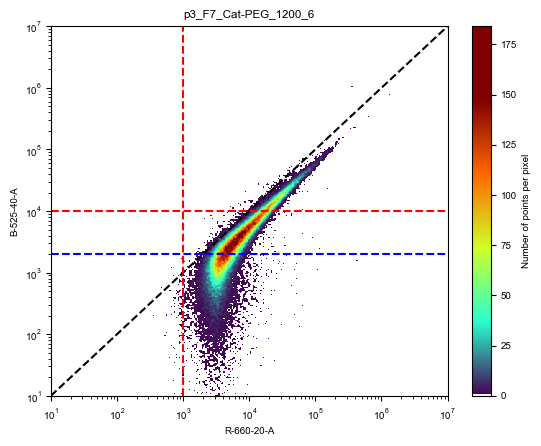

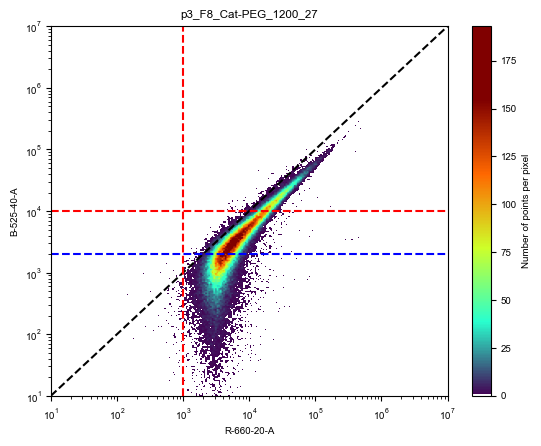

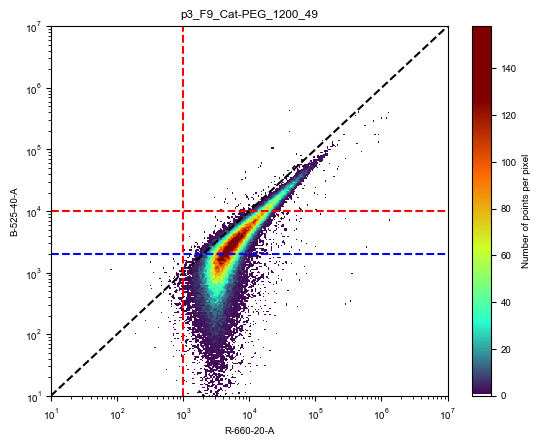

In [15]:
x_label = 'R-660-20-A'
y_label = 'B-525-40-A'

temp = all_data

for dna,df in temp[temp['lipo_class'] == 'liposome'].groupby('flow_name'):
    x = np.array(df[x_label].tolist())
    y = np.array(df[y_label].tolist())
    
    fig = plt.figure()
    using_mpl_scatter_density(fig, x, y)
    plt.title(dna)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.plot([10**1,10**7],[10**1,10**7],c='k',ls='--')
    plt.axhline(10**4,ls='--',c='red')
    plt.axhline(2000,ls='--',c='blue')
    
    plt.axvline(10**3,ls='--',c='red')
    
    plt.show()

In [16]:
lipo = all_data[all_data['lipo_class'] == 'liposome'].copy()

In [17]:
wells = ['F13','F7','F4','F9']
names = ['p1_F4_AqpZ_6','p1_F13_blank_14','p1_F7_MscL_7','p3_F1_Cat_DOPC-1200_4']
lipo[lipo['well_name'].isin(wells)].value_counts('flow_name')


flow_name
p1_F4_AqpZ_6             96959
p1_F13_blank_14          93415
p3_F9_Cat-PEG_1200_49    85744
p3_F7_Cat-PEG_1200_6     77522
p1_F7_MscL_7             55273
p3_F4_Cat-DMPC_1200_5    45503
Name: count, dtype: int64

## Plot representative flow cytometry samples for each protein

c:\Users\conar\Memplex_platform\analysis_env\Lib\site-packages\mpl_scatter_density\generic_density_artist.py:77: RuntimeWarning: All-NaN slice encountered
  vmin = self._density_vmin(array)
c:\Users\conar\Memplex_platform\analysis_env\Lib\site-packages\mpl_scatter_density\generic_density_artist.py:82: RuntimeWarning: All-NaN slice encountered
  vmax = self._density_vmax(array)


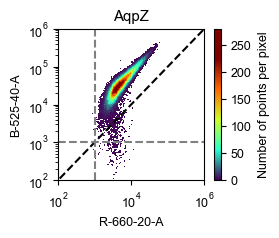

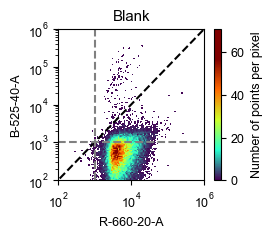

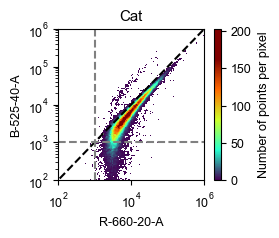

In [18]:

plt.rcParams['font.size'] = 9


white_jet = LinearSegmentedColormap.from_list('white_jet', [
    (0, '#ffffff'),
    (1e-20, '#440053'),
    (0.2, '#29ffce'),
    (0.4, '#ceff29'),
    (0.6, '#ff6800'),
    (0.8, '#800000'),
    (1, '#800000'),
], N=256)

def using_mpl_scatter_density(fig, x, y):
    ax = fig.add_subplot(1, 1, 1, projection='scatter_density')
    density = ax.scatter_density(x, y, cmap=white_jet)
    plt.xscale('log')
    plt.yscale('log')

    plt.xlim([10**2,10**6])
    plt.ylim([10**2,10**6])

    fig.colorbar(density, label='Number of points per pixel')

x_label = 'R-660-20-A'
y_label = 'B-525-40-A'

temp = lipo

# names = ['p1_F4_AqpZ_6','p1_F13_blank_14','p1_F7_MscL_7','p3_F1_Cat-DOPC_1200_4']
names = ['p1_F4_AqpZ_6','p1_F13_blank_14','p3_F1_Cat-DOPC_1200_4']

for dna,df in temp[temp['flow_name'].isin(names)].groupby('DNA_name'):
    df = df.sample(50000)
    x = np.array(df[x_label].tolist())
    y = np.array(df[y_label].tolist())
    
    fig = plt.figure(figsize=[6*cm,5*cm])
    using_mpl_scatter_density(fig, x, y)
    plt.title(dna)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.plot([10**1,10**7],[10**1,10**7],c='k',ls='--')
    # plt.axhline(10**4,ls='--',c='red')
    plt.axhline(10**3,ls='--',c='grey')
    
    plt.axvline(10**3,ls='--',c='grey')
    # plt.savefig(f'{fig_folder}/Supp_fig-{dna}_flow.svg',format='svg',dpi=300)

    plt.show()

plt.rcParams['font.size'] = 7


## Fig 1D - Investigate the ratio of GFP to Cy5
* The ratio is calculated by taking the log of the ratio of GFP to Cy5 signal
* This ratio is used to investigate the amount of protein per area of lipid so that the signal is normalized for liposome size
* The ratio is clipped at the extreme values because there are a few events that results in infinite values

In [19]:
lipo = all_data[all_data['lipo_class'] == 'liposome'].copy()

In [20]:
lipo['DNA_name'].unique()

array(['Blank', 'AqpZ', 'MscL', 'Cat'], dtype=object)

In [21]:
lipo['GFP_ratio'] = lipo['B-525-40-A'] / lipo['R-660-20-A']
lipo['GFP_ratio'] = lipo['GFP_ratio'].clip(0.001,10**4)
lipo['GFP_ratio_original'] = lipo['GFP_ratio']
lipo['GFP_ratio'] = np.log(lipo['GFP_ratio'])
lipo = lipo[lipo['GFP_ratio'].between(-6,6)]
lipo['GFP_ratio'].describe()


count    2.881087e+06
mean     3.042015e-01
std      1.938160e+00
min     -5.999675e+00
25%     -9.133311e-01
50%     -2.670241e-01
75%      2.003389e+00
max      5.258867e+00
Name: GFP_ratio, dtype: float64

In [29]:
lipo

plate well_name         FSC-H         FSC-A        SSC-H  \
7            1       A10   9580.099609   2221.800049  3821.600098   
8            1       A10  10202.799805  13491.299805  3226.500000   
9            1       A10   7590.700195  -1002.900024  2884.199951   
10           1       A10   9654.299805   4533.600098  7351.000000   
11           1       A10   6827.799805   -881.500000  4501.299805   
...        ...       ...           ...           ...          ...   
3973917      3        F9   6901.899902   4913.899902  2303.300049   
3973919      3        F9   5381.100098   4566.299805  1700.099976   
3973920      3        F9   5156.399902      1.100000  2200.300049   
3973921      3        F9   2941.199951  -8051.799805  2563.000000   
3973924      3        F9   5743.899902   1290.699951  1498.900024   

                SSC-A   B-525-40-H   B-525-40-A   B-690-50-H   B-690-50-A  \
7         8472.200195  1147.300049   563.400024   462.700012   628.500000   
8         6629.000000   647.200012   275.399994   437.299988    44.099998   
9         5027.100098  1013.200012   198.100006   443.299988    32.900002   
10       15884.599609   768.099976   955.200012  1232.000000  1206.599976   
11        9100.000000   937.799988   416.600006   650.200012   737.400024   
...               ...          ...          ...          ...          ...   
3973917   1998.199951  1728.599976  2127.899902   460.500000   216.899994   
3973919   2849.000000  1794.599976  1943.599976   473.899994   439.899994   
3973920   4416.700195  2058.800049  3959.500000   324.000000   120.300003   
3973921   3137.500000  2234.000000  3048.100098   513.400024   276.399994   
3973924   1124.199951  1498.000000   725.200012   239.699997    84.000000   

         ...  flow_number              flow_name  DNA_name  Liposome_name  \
7        ...            0         p1_A10_blank_2     Blank   DOPC_005_Cy5   
8        ...            0         p1_A10_blank_2     Blank   DOPC_005_Cy5   
9        ...            0         p1_A10_blank_2     Blank   DOPC_005_Cy5   
10       ...            0         p1_A10_blank_2     Blank   DOPC_005_Cy5   
11       ...            0         p1_A10_blank_2     Blank   DOPC_005_Cy5   
...      ...          ...                    ...       ...            ...   
3973917  ...           38  p3_F9_Cat-PEG_1200_49       Cat   DOPC_005_Cy5   
3973919  ...           38  p3_F9_Cat-PEG_1200_49       Cat   DOPC_005_Cy5   
3973920  ...           38  p3_F9_Cat-PEG_1200_49       Cat   DOPC_005_Cy5   
3973921  ...           38  p3_F9_Cat-PEG_1200_49       Cat   DOPC_005_Cy5   
3973924  ...           38  p3_F9_Cat-PEG_1200_49       Cat   DOPC_005_Cy5   

         Rep  Volume  scaled_Cy5  lipo_class  GFP_ratio  GFP_ratio_original  
7          1       0    0.619131    liposome  -2.231117            0.107408  
8          1       0    0.508553    liposome  -2.504799            0.081692  
9          1       0    0.731097    liposome  -2.920618            0.053900  
10         1       0    1.218230    liposome  -3.008584            0.049362  
11         1       0    0.612121    liposome  -2.593078            0.074790  
...      ...     ...         ...         ...        ...                 ...  
3973917    3    1200    2.346362    liposome  -0.789977            0.453855  
3973919    3    1200    1.528782    liposome  -0.806898            0.446240  
3973920    3    1200    1.215976    liposome  -0.304822            0.737255  
3973921    3    1200    2.041179    liposome  -0.742436            0.475953  
3973924    3    1200    2.827611    liposome  -1.477812            0.228136  

[2881087 rows x 44 columns]

### Statistical comparison different samples

In [65]:
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.multicomp import pairwise_tukeyhsd

def two_way_anova_with_tukey(df, value_col, factorA, factorB, alpha=0.05):
    """
    Perform a two-way ANOVA on 'value_col' with two categorical factors: 'factorA' and 'factorB'.
    Then conduct Tukey's HSD post hoc test on all group combinations if significant main/interaction effects.

    Parameters:
    -----------
    df : pandas.DataFrame
        DataFrame containing at least the columns for value_col, factorA, factorB.
        Each row corresponds to a single biological replicate (already aggregated if needed).
    value_col : str
        Column name for the numeric dependent variable (e.g., log(GFP/Cy5)).
    factorA : str
        Column name for the first categorical factor (e.g., SampleType).
    factorB : str
        Column name for the second categorical factor (e.g., SEC_status).
    alpha : float, optional
        Significance level for both ANOVA and the Tukey post hoc test. Default is 0.05.

    Returns:
    --------
    results_anova : DataFrame
        ANOVA table including degrees of freedom, sum of squares, F, and p-values for main factors and interaction.
    tukey_summary : str
        Summary of Tukey's HSD post-hoc results. None if not computed.
    """

    # 1. Fit an OLS model with interaction
    formula = f"{value_col} ~ C({factorA}) * C({factorB})"
    model = smf.ols(formula, data=df).fit()

    # 2. Perform two-way ANOVA
    results_anova = sm.stats.anova_lm(model, typ=2)
    print("Two-way ANOVA Results (Type II):")
    print(results_anova, "\n")

    # Decide if we proceed with post hoc: if any main or interaction effect is significant at alpha
    significant_factors = results_anova['PR(>F)'] < alpha
    if any(significant_factors.dropna()):
        # 3. Perform Tukey HSD on all group combinations
        #    We'll create a combined group column: e.g., 'SampleType_before', 'SampleType_after', etc.
        df['combined_group'] = df[factorA].astype(str) + "_" + df[factorB].astype(str)

        print("Performing Tukey's HSD post hoc test on all group combinations...\n")
        tukey = pairwise_tukeyhsd(
            endog=df[value_col],
            groups=df['combined_group'],
            alpha=alpha
        )
        # Extract header and rows
        headers = tukey._results_table.data[0]
        data_rows = tukey._results_table.data[1:]

        # Convert to DataFrame
        results_df = pd.DataFrame(data_rows, columns=headers)

        # Re-format the 'p-adj' column with more precision
        results_df['p-adj'] = results_df['p-adj'].astype(float).apply(lambda x: f"{x:.6e}")

        print(results_df)

        tukey_summary = tukey.summary().as_text(float_format="%.8g")
        print(tukey_summary)
    else:
        tukey_summary = None
        print(f"No main or interaction effects reached p < {alpha}. Post hoc test not performed.")

    return results_anova, tukey_summary

In [67]:
temp = lipo[lipo['Volume'] != 1350].copy()
temp = temp[temp['DNA_name'] != 'MscL']
# Convert 'Volume' to a categorical variable, 0 = pre-SEC, 1200 = post-SEC
temp['SEC_status'] = temp['Volume'].astype(str)
temp['SEC_status'] = temp['SEC_status'].replace({'0':'pre-SEC', '1200':'post-SEC'})
aggregated_df = temp.groupby(['DNA_name','SEC_status','Rep'])['GFP_ratio'].median().reset_index()
aggregated_df

aggregated_df.to_excel(f'{data_folder}/Fig1D-aggregated_flow_analysis.xlsx')

In [66]:
results_anova, tukey_summary = two_way_anova_with_tukey(
    df=aggregated_df,
    value_col='GFP_ratio',
    factorA='DNA_name',
    factorB='SEC_status',
    alpha=0.05
)
results_anova

Two-way ANOVA Results (Type II):
                              sum_sq    df           F        PR(>F)
C(DNA_name)                51.058182   2.0  206.695817  5.039110e-10
C(SEC_status)               0.018750   1.0    0.151813  7.036356e-01
C(DNA_name):C(SEC_status)   0.029533   2.0    0.119556  8.883578e-01
Residual                    1.482125  12.0         NaN           NaN 

Performing Tukey's HSD post hoc test on all group combinations...

            group1          group2  meandiff         p-adj   lower   upper  \
0    AqpZ_post-SEC    AqpZ_pre-SEC   -0.0797  9.997000e-01 -1.0435  0.8842   
1    AqpZ_post-SEC  Blank_post-SEC   -4.0545  0.000000e+00 -5.0183 -3.0906   
2    AqpZ_post-SEC   Blank_pre-SEC   -4.2098  0.000000e+00 -5.1737 -3.2460   
3    AqpZ_post-SEC    Cat_post-SEC   -2.5586  0.000000e+00 -3.5225 -1.5948   
4    AqpZ_post-SEC     Cat_pre-SEC   -2.5173  0.000000e+00 -3.4811 -1.5535   
5     AqpZ_pre-SEC  Blank_post-SEC   -3.9748  0.000000e+00 -4.9386 -3.0110   
6     A

sum_sq    df           F        PR(>F)
C(DNA_name)                51.058182   2.0  206.695817  5.039110e-10
C(SEC_status)               0.018750   1.0    0.151813  7.036356e-01
C(DNA_name):C(SEC_status)   0.029533   2.0    0.119556  8.883578e-01
Residual                    1.482125  12.0         NaN           NaN

In [45]:
print(tukey_summary)

        Multiple Comparison of Means - Tukey HSD, FWER=0.05         
    group1         group2     meandiff p-adj   lower   upper  reject
--------------------------------------------------------------------
 AqpZ_post-SEC   AqpZ_pre-SEC  -0.8303 0.1678 -1.8985  0.2379  False
 AqpZ_post-SEC Blank_post-SEC  -6.4846    0.0 -7.5528 -5.4164   True
 AqpZ_post-SEC  Blank_pre-SEC  -6.7944    0.0 -7.8625 -5.7262   True
 AqpZ_post-SEC   Cat_post-SEC  -6.5121    0.0 -7.5803 -5.4439   True
 AqpZ_post-SEC    Cat_pre-SEC  -6.3797    0.0 -7.4478 -5.3115   True
  AqpZ_pre-SEC Blank_post-SEC  -5.6544    0.0 -6.7225 -4.5862   True
  AqpZ_pre-SEC  Blank_pre-SEC  -5.9641    0.0 -7.0323 -4.8959   True
  AqpZ_pre-SEC   Cat_post-SEC  -5.6818    0.0   -6.75 -4.6137   True
  AqpZ_pre-SEC    Cat_pre-SEC  -5.5494    0.0 -6.6176 -4.4812   True
Blank_post-SEC  Blank_pre-SEC  -0.3097 0.9178 -1.3779  0.7585  False
Blank_post-SEC   Cat_post-SEC  -0.0275    1.0 -1.0957  1.0407  False
Blank_post-SEC    Cat_pre-SEC    0

In [22]:
t = lipo[lipo['Volume'] == 0]
print('Pre-SEC')

aqpz = t[t['DNA_name'] == 'AqpZ']
cat = t[t['DNA_name'] == 'Cat']

blank = t[t['DNA_name'] == 'Blank']

gfp = ttest_ind(aqpz['GFP_ratio_original'],blank['GFP_ratio_original'])[1]
fold_diff = aqpz['GFP_ratio_original'].median() / blank['GFP_ratio_original'].median()
print(f'AqpZ-Blank - GFP:{gfp}   diff:{fold_diff}')

gfp = ttest_ind(aqpz['GFP_ratio_original'],cat['GFP_ratio_original'])[1]
fold_diff = aqpz['GFP_ratio_original'].median() / cat['GFP_ratio_original'].median()
print(f'AqpZ-Cat - GFP:{gfp}   diff:{fold_diff}')

gfp = ttest_ind(cat['GFP_ratio_original'],blank['GFP_ratio_original'])[1]
fold_diff = cat['GFP_ratio_original'].median() / blank['GFP_ratio_original'].median()
print(f'Cat-Blank - GFP:{gfp}   diff:{fold_diff}')


Pre-SEC
AqpZ-Blank - GFP:0.0   diff:60.6969377130485
AqpZ-Cat - GFP:0.0   diff:11.882335472043698
Cat-Blank - GFP:0.0   diff:5.108165634260531


In [23]:
t = lipo[lipo['Volume'] == 1200]
print('Post-SEC')

aqpz = t[t['DNA_name'] == 'AqpZ']
cat = t[t['DNA_name'] == 'Cat']

blank = t[t['DNA_name'] == 'Blank']

gfp = ttest_ind(aqpz['GFP_ratio_original'],blank['GFP_ratio_original'])[1]
fold_diff = aqpz['GFP_ratio_original'].median() / blank['GFP_ratio_original'].median()
print(f'AqpZ-Blank - GFP:{gfp}   diff:{fold_diff}')

gfp = ttest_ind(aqpz['GFP_ratio_original'],cat['GFP_ratio_original'])[1]
fold_diff = aqpz['GFP_ratio_original'].median() / cat['GFP_ratio_original'].median()
print(f'AqpZ-Cat - GFP:{gfp}   diff:{fold_diff}')

gfp = ttest_ind(cat['GFP_ratio_original'],blank['GFP_ratio_original'])[1]
fold_diff = cat['GFP_ratio_original'].median() / blank['GFP_ratio_original'].median()
print(f'Cat-Blank - GFP:{gfp}   diff:{fold_diff}')


Post-SEC
AqpZ-Blank - GFP:0.0   diff:58.596665267069696
AqpZ-Cat - GFP:0.0   diff:12.818372261361658
Cat-Blank - GFP:2.3834190871803548e-64   diff:4.571303132122108


In [25]:
colors = ["#0072B2", "#000000", "#D2042D"] # Blue, black, red
hue_order = ['AqpZ', 'Blank', 'Cat']
sns.set_palette(sns.color_palette(colors))

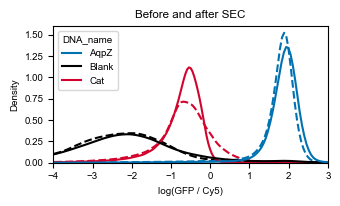

In [51]:
fig,ax = plt.subplots(figsize=[9*cm,4.5*cm])

temp = lipo[lipo['Volume'] == 0]
sns.kdeplot(data=temp,x='GFP_ratio',hue='DNA_name',ax=ax,hue_order=hue_order,fill=False,ls='--',common_norm=False)
temp = lipo[lipo['Volume'] == 1200]
sns.kdeplot(data=temp,x='GFP_ratio',hue='DNA_name',ax=ax,hue_order=hue_order,fill=False,common_norm=False)

plt.title('Before and after SEC')

ax.set_xlabel('log(GFP / Cy5)')
plt.xlim(-4,3)

# plt.savefig(f'{fig_folder}/Fig1D-pre_post_SEC_flow_simple.svg',format='svg',dpi=300)

plt.show()

### Export final dataset

In [27]:
export = lipo[lipo['DNA_name'] != 'MscL']
export = export[export['Volume'] != 1350]
export = export[['SSC-A','R-660-20-A','B-525-40-A', 'DNA_name',
       'Rep', 'Volume', 'scaled_Cy5','GFP_ratio', 'GFP_ratio_original']].copy()
export['Filtered'] = export['Volume'].apply(lambda x: 'No' if x == 0 else 'Yes')
export = export.drop(columns=['Volume'])
export

SSC-A    R-660-20-A   B-525-40-A DNA_name  Rep  scaled_Cy5  \
7         8472.200195   5245.399902   563.400024    Blank    1    0.619131   
8         6629.000000   3371.199951   275.399994    Blank    1    0.508553   
9         5027.100098   3675.300049   198.100006    Blank    1    0.731097   
10       15884.599609  19351.099609   955.200012    Blank    1    1.218230   
11        9100.000000   5570.299805   416.600006    Blank    1    0.612121   
...               ...           ...          ...      ...  ...         ...   
3973917   1998.199951   4688.500000  2127.899902      Cat    3    2.346362   
3973919   2849.000000   4355.500000  1943.599976      Cat    3    1.528782   
3973920   4416.700195   5370.600098  3959.500000      Cat    3    1.215976   
3973921   3137.500000   6404.200195  3048.100098      Cat    3    2.041179   
3973924   1124.199951   3178.800049   725.200012      Cat    3    2.827611   

         GFP_ratio  GFP_ratio_original Filtered  
7        -2.231117            0.107408       No  
8        -2.504799            0.081692       No  
9        -2.920618            0.053900       No  
10       -3.008584            0.049362       No  
11       -2.593078            0.074790       No  
...            ...                 ...      ...  
3973917  -0.789977            0.453855      Yes  
3973919  -0.806898            0.446240      Yes  
3973920  -0.304822            0.737255      Yes  
3973921  -0.742436            0.475953      Yes  
3973924  -1.477812            0.228136      Yes  

[2210323 rows x 9 columns]

In [55]:
# export.to_pickle(f'./{data_folder}/Fig1D-Flow cytometry data.pkl')

In [28]:
names = ['p1_F4_AqpZ_6','p1_F13_blank_14','p1_F7_MscL_7','p3_F1_Cat-DOPC_1200_4']

export = lipo[lipo['flow_name'].isin(names)]
export = export[['SSC-A','R-660-20-A','B-525-40-A', 'DNA_name',
       'Rep', 'Volume', 'scaled_Cy5','GFP_ratio', 'GFP_ratio_original']].copy()
export['Filtered'] = export['Volume'].apply(lambda x: 'No' if x == 0 else 'Yes')
export = export.drop(columns=['Volume'])
# export.to_pickle(f'./{data_folder}/Supp_Fig-Flow cytometry data.pkl')

# Fig1E - Plate reader comparison to flow data
* Use median GFP/Cy5 ratio values for each sample and plot them against the pmol value from the plate reader measurement

In [29]:
plate_flow = pd.read_pickle('/'.join([data_folder,'./Fig1E-plate_flow_comp.pkl']))
plate_flow

plate well_name         FSC-H         FSC-A         SSC-H  \
2150218      3       B11   3753.800049  -2236.800049   2633.199951   
2150219      3       B11   3832.000000  -2682.899902  15284.400391   
2150220      3       B11   4965.299805   -860.700012   2809.199951   
2150221      3       B11   6968.500000   3747.000000   4877.500000   
2150222      3       B11  12623.400391  14882.599609  16985.300781   
...        ...       ...           ...           ...           ...   
4886569      3        O5   5301.100098  -2743.500000   9436.700195   
4886570      3        O5   5612.200195   2416.899902   9973.799805   
4886571      3        O5   4734.899902   2450.500000   3289.500000   
4886572      3        O5   6334.000000   4064.600098   2699.399902   
4886573      3        O5   4144.700195  -4113.700195   3412.300049   

                SSC-A    B-525-40-H     B-525-40-A   B-690-50-H   B-690-50-A  \
2150218   3690.100098   2008.900024    1163.099976   571.700012   699.200012   
2150219  31461.099609   6314.100098   11232.900391  1117.199951  1998.500000   
2150220   6360.000000   1417.599976    1548.199951   768.200012   855.700012   
2150221   9054.700195   3443.800049    3533.600098   621.599976   493.299988   
2150222  25109.300781   2366.399902    4532.299805   821.500000  1120.699951   
...               ...           ...            ...          ...          ...   
4886569  21740.900391  74743.101562  167058.296875   860.400024  1315.099976   
4886570  21052.800781  11523.200195   23001.800781   664.400024   920.000000   
4886571   4923.399902   2993.000000    1777.800049   521.599976   339.200012   
4886572   4636.200195   3637.000000    3661.899902   503.600006   373.500000   
4886573   6669.799805   3802.300049    3000.600098   119.599998  -663.700012   

         ...  DNA_conc  Liposome_name      pmol  pmol_sub  Rep  Volume  \
2150218  ...    0.3125  DOPC_0025_Cy5  4.003028  0.770909  NaN     NaN   
2150219  ...    0.3125  DOPC_0025_Cy5  4.003028  0.770909  NaN     NaN   
2150220  ...    0.3125  DOPC_0025_Cy5  4.003028  0.770909  NaN     NaN   
2150221  ...    0.3125  DOPC_0025_Cy5  4.003028  0.770909  NaN     NaN   
2150222  ...    0.3125  DOPC_0025_Cy5  4.003028  0.770909  NaN     NaN   
...      ...       ...            ...       ...       ...  ...     ...   
4886569  ...    0.6250  DOPC_0025_Cy5  5.848322  2.897565  NaN     NaN   
4886570  ...    0.6250  DOPC_0025_Cy5  5.848322  2.897565  NaN     NaN   
4886571  ...    0.6250  DOPC_0025_Cy5  5.848322  2.897565  NaN     NaN   
4886572  ...    0.6250  DOPC_0025_Cy5  5.848322  2.897565  NaN     NaN   
4886573  ...    0.6250  DOPC_0025_Cy5  5.848322  2.897565  NaN     NaN   

         rxn_type  scaled_Cy5  lipo_class  GFP_ratio  
2150218     print    1.031110    liposome  -1.185201  
2150219     print    0.591140    liposome  -0.504202  
2150220     print    0.534513    liposome  -0.786535  
2150221     print    0.458546    liposome  -0.161273  
2150222     print    0.308603    liposome  -0.536308  
...           ...         ...         ...        ...  
4886569     print    0.538832    liposome   2.657498  
4886570     print    0.449228    liposome   0.888764  
4886571     print    0.431430    liposome  -0.177972  
4886572     print    0.859475    liposome  -0.084480  
4886573     print    0.476206    liposome  -0.056873  

[1051560 rows x 47 columns]

C:\Users\conar\AppData\Local\Temp\ipykernel_4844\3132893754.py:8: FutureWarning: The provided callable <function median at 0x0000021CD5042200> is currently using DataFrameGroupBy.median. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "median" instead.
  medians = plate_flow.groupby(['DNA_name','pmol'])[['GFP_ratio']].agg(np.median).reset_index()


0.8983027016479047


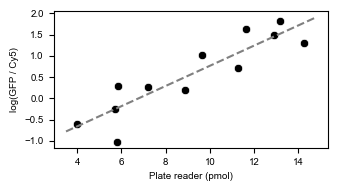

In [30]:
def abline(slope, intercept,color='red'):
    """Plot a line from slope and intercept"""
    axes = plt.gca()
    x_vals = np.array(axes.get_xlim())
    y_vals = intercept + slope * x_vals
    plt.plot(x_vals, y_vals, '--',color=color)

medians = plate_flow.groupby(['DNA_name','pmol'])[['GFP_ratio']].agg(np.median).reset_index()
fig,ax = plt.subplots(figsize=[9*cm,4.5*cm])

sns.scatterplot(data=medians,x='pmol',y='GFP_ratio',color='black',ax=ax)

slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(medians['pmol'],medians['GFP_ratio'])
abline(slope, intercept,color='grey')

# plt.title('Plate reader versus flow cytometry')
ax.set_ylabel('log(GFP / Cy5)')
ax.set_xlabel('Plate reader (pmol)')


plt.savefig(f'{fig_folder}/Fig1E-plate_reader_v_flow_AqpZ.svg',format='svg',dpi=300)

print(r_value)
plt.show()

In [66]:
# medians.to_excel(f'./{data_folder}/Fig_1E-plate_flow_comp.xlsx')

# Previous analysis including MscL

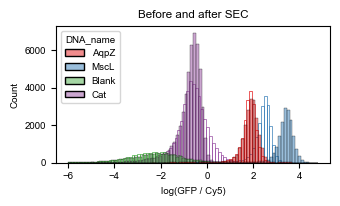

In [35]:
fig,ax = plt.subplots(figsize=[9*cm,4.5*cm])

temp = lipo[lipo['Volume'] == 0].sample(100000)
sns.histplot(data=temp,x='GFP_ratio',hue='DNA_name',ax=ax,palette='Set1',hue_order=['AqpZ','MscL','Blank','Cat'],fill=False)
temp = lipo[lipo['Volume'] == 1200].sample(100000)
sns.histplot(data=temp,x='GFP_ratio',hue='DNA_name',ax=ax,palette='Set1',hue_order=['AqpZ','MscL','Blank','Cat'],fill=True)
# temp = lipo[lipo['Volume'] == 1200].sample(10000)
# sns.displot(data=temp,x='GFP_ratio',hue='DNA_name',ax=ax,palette='Set1',hue_order=['Blank','Cat','AqpZ','MscL'])

plt.title('Before and after SEC')

ax.set_xlabel('log(GFP / Cy5)')

plt.savefig(f'{fig_folder}/pre_post_SEC_flow.svg',format='svg',dpi=300)

plt.show()

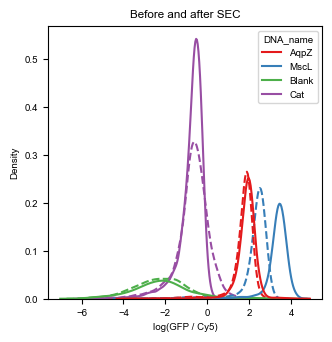

In [84]:
# fig,ax = plt.subplots(figsize=[6,6])
fig,ax = plt.subplots(figsize=[9*cm,9*cm])

temp = lipo[lipo['Volume'] == 0].sample(10000)
sns.kdeplot(data=temp,x='GFP_ratio',hue='DNA_name',ax=ax,palette='Set1',hue_order=['AqpZ','MscL','Blank','Cat'],ls='--')

temp = lipo[lipo['Volume'] == 1200].sample(10000)
sns.kdeplot(data=temp,x='GFP_ratio',hue='DNA_name',ax=ax,palette='Set1',hue_order=['AqpZ','MscL','Blank','Cat'])

plt.title('Before and after SEC')

ax.set_xlabel('log(GFP / Cy5)')

plt.savefig(f'{fig_folder}/pre_post_SEC_flow.svg',format='svg',dpi=300)

plt.show()

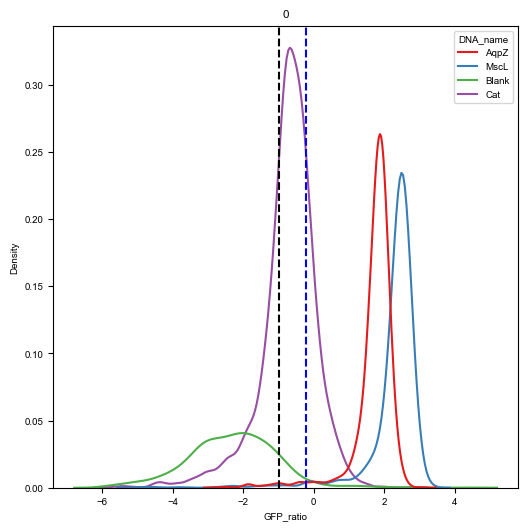

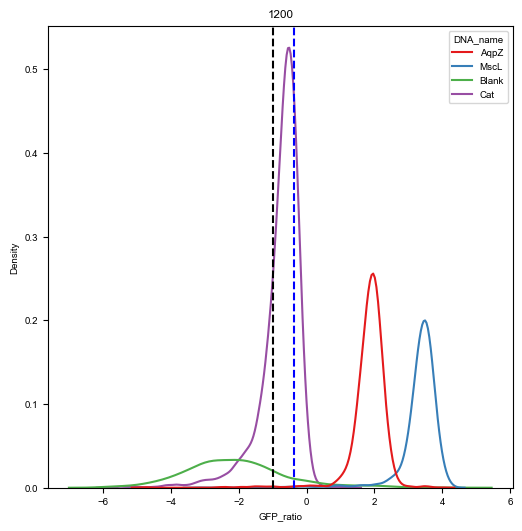

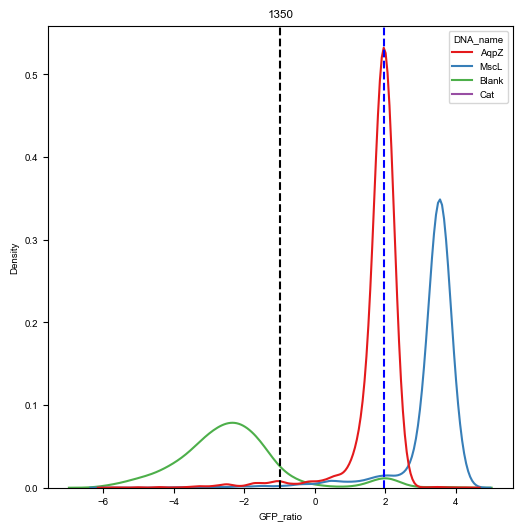

In [83]:
for dna,dna_df in lipo.groupby('Volume'):
    fig,ax = plt.subplots(figsize=[6,6])
    temp = dna_df.sample(10000)

    med = np.median(temp['GFP_ratio'])

    sns.kdeplot(data=temp,x='GFP_ratio',hue='DNA_name',ax=ax,palette='Set1',hue_order=['AqpZ','MscL','Blank','Cat'])
    plt.axvline(med,color='blue',ls='--')
    # plt.axvline(high_med,color='blue',ls='--')
    plt.axvline(-1,color='black',ls='--')
    
    # plt.axvline(high_thresh,color='black',ls='--')
    plt.title(dna)
    plt.show()